In [0]:
_git_branch = 'charters-limitations'

#Document parser, refer https://github.com/nemoware/document-parser/releases
lib_version = '1.1.15'

# INIT (comon for the project)

## pull code

In [55]:
!pip install pyjarowinkler

In [54]:
import json
import subprocess
import sys
import time

import numpy as np
from IPython.core.display import display, HTML
from google.colab import files

!pip install overrides

Ничто = None



def exec(x):
  r = subprocess.check_output(x, shell=True)
  r = r.decode('unicode-escape').encode('latin1').decode('utf8')
  print(r)


print(f"fetching code from GitHub.....{_git_branch}")
try:
  exec('rm -r nlp_tools')
except:
  pass
exec(f'git clone --single-branch --branch {_git_branch} https://github.com/nemoware/analyser.git nlp_tools')

print('🦊 GIT revision:')
exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

sys.path.insert(0, 'nlp_tools')

print('❤️importing Code from GitHub ... DONE')






 

fetching code from GitHub.....charters-limitations


🦊 GIT revision:
1134
* charters-limitations
Tune split_into_sentences

Organize code

+charter_sentence_max_len param


❤️importing Code from GitHub ... DONE


#### rendering tools

In [0]:

#----
import matplotlib as mpl
from colab_support.renderer import HtmlRenderer
from analyser.documents import TextMap
from analyser.legal_docs import DocumentJson

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range, separator=separator)

   
renderer_ = DemoRenderer()


 
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_similarity(matrix, rotation):  
  sns.set(font_scale=1.0)
  g = sns.heatmap(
      matrix,
      vmin=matrix.min(),
      vmax=matrix.max(),
      annot=False, 
      cmap="YlOrRd"
  )

### imports

In [0]:
import os
import pickle
import unittest

import numpy as np

from analyser.contract_parser import ContractAnlysingContext, ContractDocument
from analyser.contract_parser import find_value_sign_currency_attention
 
from analyser.hyperparams import HyperParameters
from analyser.parsing import AuditContext

from analyser.legal_docs import LegalDocument, ContractValue
from analyser.ml_tools import *
from analyser.patterns import *
from analyser.text_tools import *

from tf_support.embedder_elmo import ElmoEmbedder
 

In [57]:
from tf_support.embedder_elmo import ElmoEmbedder
elmo_embedder = ElmoEmbedder()
elmo_embedder_default = ElmoEmbedder(layer_name='default')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Compare subjects

### Read data

In [58]:
import pandas as pd
import analyser.hyperparams as hp
codebasepath = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(hp.__file__)))

samples = pd.read_csv(os.path.join(codebasepath, 'vocab', 'charter.limitations.samples.csv'))
samples

,"Тип документа\n (Договор, \n Протокол, \n Устав)",Наименование,Полное предложение,Unnamed: 3,Unnamed: 4
0,Устав,Сделки,принятие решений о совершении сделок (в том чи...,принятие решений о совершении сделок (в том чи...,NaN
1,Устав,Сделки с имуществом,сделок (в том числе нескольких взаимосвязанных...,и сделок (в том числе нескольких взаимосвязанн...,NaN
2,Устав,Сделки с займами/кредитами,"принятие решений о совершении сделок, связанны...",NaN,принятие решения о согласии на совершение или ...
3,Устав,Продажа и отчуждение недвижимого имущества,"принятие решений о совершении сделок, связанны...",NaN,принятие решения о согласии на совершение или ...
4,Устав,Передача в аренду,"принятие решений о совершении сделок, связанны...",NaN,принятие решения о согласии на совершение или ...
5,Устав,Получение в аренду недвижимого имущества,"принятие решений о совершении сделок, связанны...",NaN,NaN
6,Устав,Отказ от аренды земельных участков,принятие решений об отказе от аренды/субаренды...,NaN,NaN
7,Устав,Сделки с ценными бумагами,"принятие решений о совершении сделок, связанны...",NaN,принятие решения о согласии на совершение или ...
8,Устав,Сделки передачи в залог уставных капиталов и а...,"принятие решений о совершении сделок, связанны...",NaN,NaN
9,Устав,Благотворительность,"принятие решений о совершении сделок мены, дар...",NaN,принятие решения о согласии на совершение или ...


### Sample data

In [59]:
sampled = samples.T[2:3].values.flatten()[:12]
sampled

array(['принятие решений о совершении сделок (в том числе нескольких взаимосвязанных сделок) на сумму, превышающую 100 000 000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте),',
       'сделок (в том числе нескольких взаимосвязанных сделок) с имуществом Общества, стоимость которого на основании данных бухгалтерской отчетности Общества за последний отчетный период, предшествующий дню принятия решения о совершении таких сделок, превышает 100 000 000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте), за исключением сделок, совершаемых в процессе обычной хозяйственной деятельности Общества, а также, за исключением сделок с ПАО «Газпром нефть» и обществами, входящими в группу лиц с ним когда такая сделка или несколько взаимосвязанных сделок является(-ются) сделкой, в совершении которой имеется заинтересованность);',
       'принятие решений о совершении сделок, связанных с получением или предоставлением Об

In [60]:
headlines = samples.T[1:2].values.flatten()[:12]
headlines

array(['Сделки', 'Сделки с имуществом', 'Сделки с займами/кредитами',
       'Продажа и отчуждение недвижимого имущества', 'Передача в аренду',
       'Получение в аренду недвижимого имущества',
       'Отказ от аренды земельных участков', 'Сделки с ценными бумагами',
       'Сделки передачи в залог уставных капиталов и акций',
       'Благотворительность', 'Сделки с заинтересованностью',
       'Крупная сделка'], dtype=object)

### Explore sentences, 
length, tokens, etc

In [0]:
embeddings = elmo_embedder_default.embedd_strings(sampled)
K=embeddings.shape[0]

## Collisions
ограничения уставов, которые слишком близки по эмбеддингу

### making distance matrix

In [0]:
import scipy.spatial.distance as distance
min_d=1
min_ab=(0,0)
mtx = np.zeros(shape=(K,K)) 
collisions = []

for x, e1 in enumerate(embeddings):
  for y, e2 in enumerate(embeddings):
    if x!=y:
      d = distance.cosine(e1,e2)
      mtx[x,y] = d  


----------------------------------------------------------------------------------------------------
mean distance is 0.15260523557662964
median distance is 0.1362227499485016
so threshold is estimated to be 0.0681113749742508  (=median/2)
----------------------------------------------------------------------------------------------------
COLLISIONS
Semantic distance is 0.06 between [Сделки с ценными бумагами] and [Сделки передачи в залог уставных капиталов и акций]
 [принятие решений о совершении сделок, связанных с приобретением или отчуждением долей в уставных капиталах, акций, облигаций, закладных, векселей или иных ценных бумаг или любых прав в отношении такого имущества (путем конвертации, подписки, опционов или иным способом) любой компании или другой организации, за исключением сделок с ПАО «Газпром нефть» и обществами, входящими в группу лиц с ним;] 
 [принятие решений о совершении сделок, связанных с передачей в залог или установлением иных обременений в отношении принадлежащ

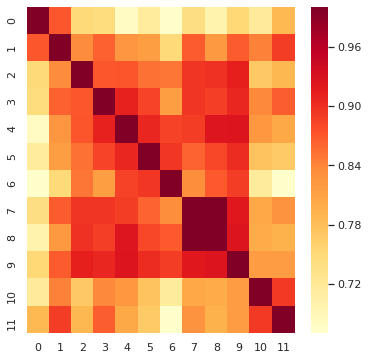

In [85]:

median = np.median(mtx)
threshold = median/2

print('-'*100)
# print(f'max distance is { max(mtx) }')
print(f'mean distance is {np.mean(mtx)}')
print(f'median distance is {median}')
print(f'so threshold is estimated to be {threshold}  (=median/2)')
for x, e1 in enumerate(embeddings):
  for y, e2 in enumerate(embeddings):
    if x!=y:
      if mtx[x,y] < threshold:
        collision = ( min([x, y]), max([x, y]) )
        if collision not in collisions:
          collisions.append(collision)
        

print('-'*100)
print('collisions'.upper())
for c in collisions:
  d = mtx[c[0], c[1]]
  print(f'Semantic distance is {d:1.2f} between [{headlines[c[0]]}] and [{headlines[c[1]]}]')
  print(f' [{sampled[c[0]]}] \n [{sampled[c[1]]}]')
  print('-'*10)


plt.figure('similarity', figsize=(6,6))
plot_similarity( 1.0 - relu(mtx, threshold), 0)

# Split long sample sentences

In [116]:
from analyser.legal_docs import tokenize_doc_into_sentences_map

for k, s in enumerate(sampled):
  print()
  print()
  print(f'🤖 {k}. {headlines[k].upper()}')
  sentences = tokenize_doc_into_sentences_map(LegalDocument(s).parse(), HyperParameters.charter_sentence_max_len)
  print(f'\t{len(sentences)} {HyperParameters.charter_sentence_max_len}-long-segements' )
  for i in range(len(sentences)):
    print (f'\t\t{len(sentences[i])}\t👾',sentences[i])




🤖 0. СДЕЛКИ
	2 200-long-segements
		94	👾 принятие решений о совершении сделок (в том числе нескольких взаимосвязанных сделок) на сумму,
		115	👾  превышающую 100000000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте),


🤖 1. СДЕЛКИ С ИМУЩЕСТВОМ
	4 200-long-segements
		180	👾 сделок (в том числе нескольких взаимосвязанных сделок) с имуществом Общества, стоимость которого на основании данных бухгалтерской отчетности Общества за последний отчетный период,
		199	👾  предшествующий дню принятия решения о совершении таких сделок, превышает 100000000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте), за исключением сделок,
		135	👾  совершаемых в процессе обычной хозяйственной деятельности Общества, а также, за исключением сделок с ПАО «Газпром нефть» и обществами,
		160	👾  входящими в группу лиц с ним когда такая сделка или несколько взаимосвязанных сделок является(-ются) сделкой, в совершении которой имеется 

In [66]:
def cut_long_sentences(sentences:[str], max_len=HyperParameters.charter_sentence_max_len):
  spans=[]
  sents=[]
  for k, s in enumerate(sentences):
    smalls = tokenize_doc_into_sentences_map(LegalDocument(s).parse(), max_len)    
    spans.append ( slice(len(sents),  len(sents)+len(smalls)))
    sents += smalls
  return sents, spans

 

sents, spans = cut_long_sentences(sampled)
for i,s in enumerate(spans):
  print()
  print (sents[s])

pieces_embs = elmo_embedder_default.embedd_strings(sents)
pieces_embs.shape


['принятие решений о совершении сделок (в том числе нескольких взаимосвязанных сделок) на сумму,', ' превышающую 100000000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте),']

['сделок (в том числе нескольких взаимосвязанных сделок) с имуществом Общества, стоимость которого на основании данных бухгалтерской отчетности Общества за последний отчетный период,', ' предшествующий дню принятия решения о совершении таких сделок, превышает 100000000 (сто миллионов) рублей без учета НДС (или эквивалент указанной суммы в любой другой валюте), за исключением сделок,', ' совершаемых в процессе обычной хозяйственной деятельности Общества, а также, за исключением сделок с ПАО «Газпром нефть» и обществами,', ' входящими в группу лиц с ним когда такая сделка или несколько взаимосвязанных сделок является(-ются) сделкой, в совершении которой имеется заинтересованность);']

['принятие решений о совершении сделок, связанных с получением или предоставлением Общес

(36, 1024)

In [67]:
headline_to_emb = {}
for i,s in enumerate(spans):
  e = pieces_embs[s]
  headline_to_emb[ headlines[i] ] = e

print('shapes of the patterns')
for h in headline_to_emb:
  print( headline_to_emb[h].shape, h)

shapes of the patterns
(2, 1024) Сделки
(4, 1024) Сделки с имуществом
(2, 1024) Сделки с займами/кредитами
(5, 1024) Продажа и отчуждение недвижимого имущества
(3, 1024) Передача в аренду
(2, 1024) Получение в аренду недвижимого имущества
(1, 1024) Отказ от аренды земельных участков
(3, 1024) Сделки с ценными бумагами
(2, 1024) Сделки передачи в залог уставных капиталов и акций
(2, 1024) Благотворительность
(3, 1024) Сделки с заинтересованностью
(7, 1024) Крупная сделка


## Searching patterns in a fake syntetic charter

In [0]:
from analyser.charter_parser import CharterDocument
fake_contract_text='\n'.join(sampled)
fake_contract = CharterDocument(LegalDocument(fake_contract_text)).parse()
# fake_contract.sentence_map.tokens

In [69]:
# distance.cosine(u.mean(0), v.mean(0))
_first_key = list(headline_to_emb.keys())[0]
_first_emb = headline_to_emb[_first_key][0]
_first_emb.shape

(1024,)

In [0]:
from analyser.legal_docs import embedd_sentences
fake_contract.sentences_embeddings = embedd_sentences(fake_contract.sentence_map, elmo_embedder_default)

In [104]:
 
def attention_vector(pattern_emb, text_emb):
  return np.array ([ 1.0-distance.cosine(e, pattern_emb) for e in  text_emb])

def multi_attention_vector (patterns_emb, text_emb):
  vectors=[]
  for pattern_emb in patterns_emb:
    av = attention_vector(pattern_emb, text_emb)
    vectors.append(av)

  return max_exclusive_pattern(vectors)

def best_window(attention_vector, wnd_len):
  max_sum=0
  best_index=0
  for k in range(len(attention_vector)-wnd_len+1):
    wnd = attention_vector[k:k+wnd_len]
    _sum=sum(wnd)
    if _sum > max_sum:
      max_sum=_sum
      best_index=k
  return best_index, max_sum, max_sum/wnd_len

  
##-----------TEST
av = attention_vector(_first_emb, fake_contract.sentences_embeddings)
renderer_.render_color_text(fake_contract.sentence_map.tokens,  av, separator='<br>', _range=(0,1))

In [98]:

##-----------TEST
_sample_key='Продажа и отчуждение недвижимого имущества'
print(_sample_key, len(headline_to_emb[_sample_key]))
avs = multi_attention_vector (headline_to_emb[_sample_key], fake_contract.sentences_embeddings)
renderer_.render_color_text(fake_contract.sentence_map.tokens,  avs, separator='<br>', _range=(0,1))

Продажа и отчуждение недвижимого имущества 5


In [111]:
##-----------TEST
best_index, max_sum, confidence = best_window(avs, 5)
print(f'Confidence {confidence:1.4f}' )
fake_contract.sentence_map.text_range( [best_index, best_index+5] )

_slice = slice(best_index, best_index+5)
renderer_.render_color_text(fake_contract.sentence_map.tokens[_slice],  avs[_slice], separator='<br>', _range=(0,1))

Confidence 0.9952


# Find all samplese in syntetic charter

In [123]:
for key in headline_to_emb.keys():
  embedding_for_key=headline_to_emb[key]
  pieces=len(embedding_for_key)
  avs = multi_attention_vector (embedding_for_key, fake_contract.sentences_embeddings)
  best_index, max_sum, confidence = best_window(avs, pieces)

  
  print('='*90)
  print(key.upper())
  print(f'Confidence {confidence:1.4f}' )
  _slice = slice(best_index, best_index+pieces)
  renderer_.render_color_text(fake_contract.sentence_map.tokens[_slice],  avs[_slice], separator='<br>', _range=(0,5))
  print()


СДЕЛКИ
Confidence 0.9950



СДЕЛКИ С ИМУЩЕСТВОМ
Confidence 0.9963



СДЕЛКИ С ЗАЙМАМИ/КРЕДИТАМИ
Confidence 0.9969



ПРОДАЖА И ОТЧУЖДЕНИЕ НЕДВИЖИМОГО ИМУЩЕСТВА
Confidence 0.9952



ПЕРЕДАЧА В АРЕНДУ
Confidence 0.9742



ПОЛУЧЕНИЕ В АРЕНДУ НЕДВИЖИМОГО ИМУЩЕСТВА
Confidence 0.9877



ОТКАЗ ОТ АРЕНДЫ ЗЕМЕЛЬНЫХ УЧАСТКОВ
Confidence 0.9862



СДЕЛКИ С ЦЕННЫМИ БУМАГАМИ
Confidence 0.9894



СДЕЛКИ ПЕРЕДАЧИ В ЗАЛОГ УСТАВНЫХ КАПИТАЛОВ И АКЦИЙ
Confidence 0.9868



БЛАГОТВОРИТЕЛЬНОСТЬ
Confidence 0.9865



СДЕЛКИ С ЗАИНТЕРЕСОВАННОСТЬЮ
Confidence 0.9905



КРУПНАЯ СДЕЛКА
Confidence 0.9935
